In [6]:
from src.model import HangmanTransformer
from src.dataset import HangmanDataset
import torch
import torch.nn as nn
import os

vocab =  [chr(i) for i in range(97, 123)] + ['<SOS>', '<MASK>', '<PAD>']
vocab_size = len(vocab)
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for i, ch in enumerate(vocab)}

loadModel= True
checkpoint_path = 'trained_models'
checkpoint_file = 'checkpoint.49th'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = HangmanTransformer(vocab_size=29)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)

if (loadModel):
    checkpoint = torch.load(os.path.join(checkpoint_path,checkpoint_file))
    # print(checkpoint['model_state_dict'])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print('loaded' )


# model = model.to(device)
criterion = nn.BCEWithLogitsLoss(reduction='none')

cuda
loaded


In [64]:
import random
from tqdm import tqdm

# Set the seed for reproducibility
SEED = 42
random.seed(SEED)

# Read and clean words
with open('words_250000_train.txt', 'r') as file:
    training_words = [line.strip().lower() for line in file if line.strip().isalpha()]

# Group words by their lengths
word_dict_by_len = {}
for word in tqdm(training_words):
    l = len(word)
    word_dict_by_len.setdefault(l, []).append(word)


100%|████████████████████████████████████████████████████████████| 227300/227300 [00:00<00:00, 2021992.24it/s]


In [60]:
36705/68204

0.5381649170136649

In [12]:
40250/68204

0.5901413406838308

word length of 3
creating dataset


100%|█████████████████████████████████████████████████████████████████████████| 42/42 [00:20<00:00,  2.06it/s]

total test words: 661
total wins: 42


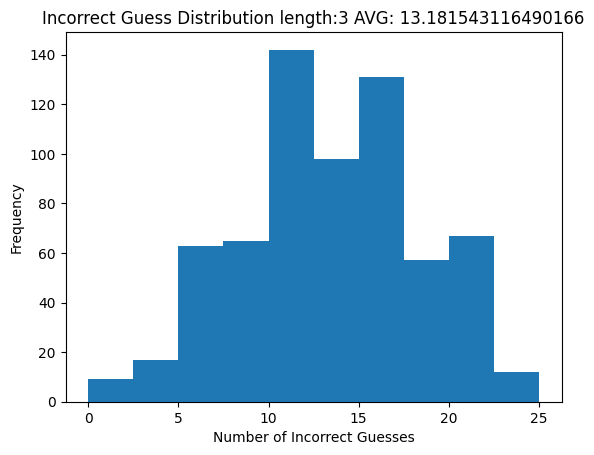

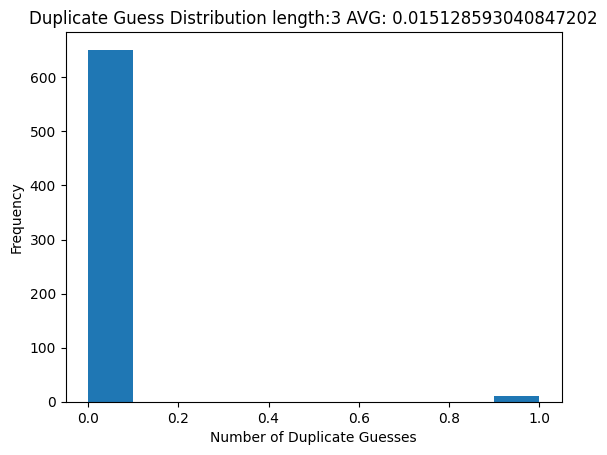

word length of 6
creating dataset


100%|███████████████████████████████████████████████████████████████████████| 367/367 [02:54<00:00,  2.11it/s]


total test words: 5863
total wins: 1601


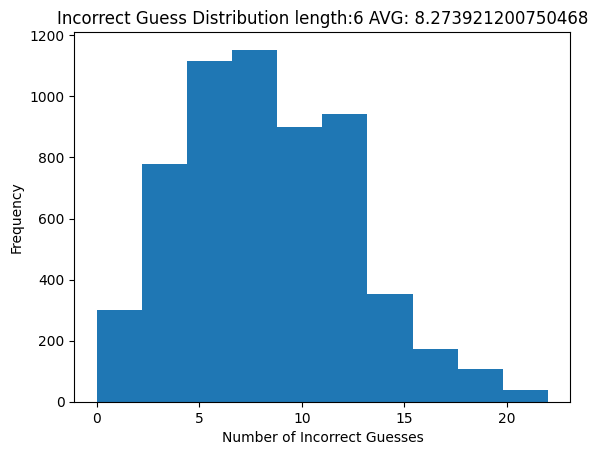

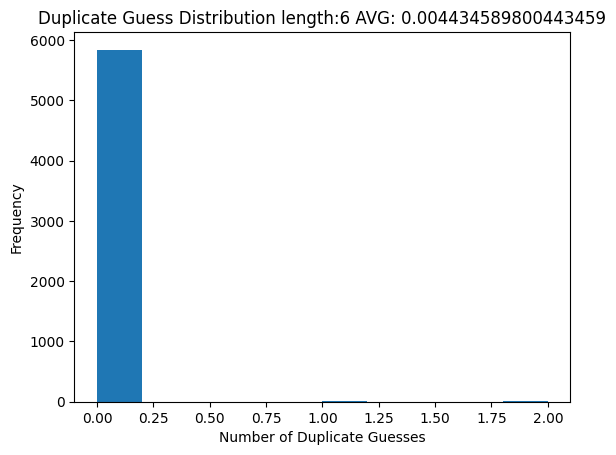

word length of 4
creating dataset


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.16it/s]


total test words: 1587
total wins: 282


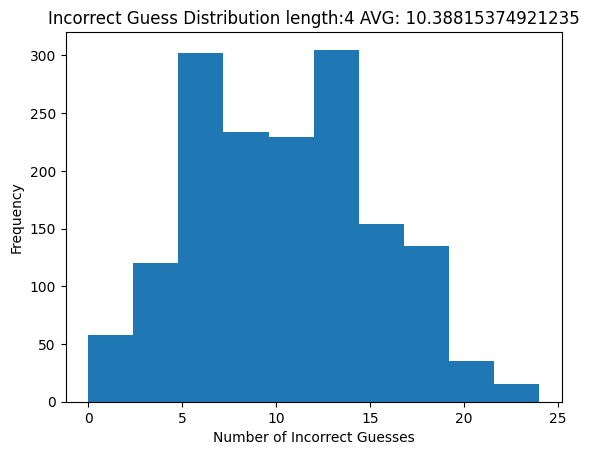

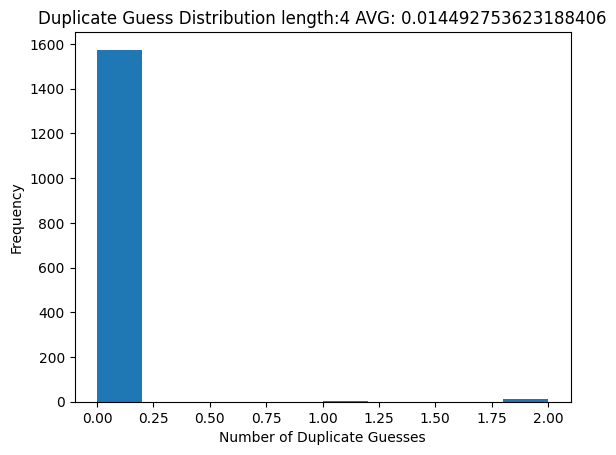

word length of 5
creating dataset


100%|███████████████████████████████████████████████████████████████████████| 212/212 [01:39<00:00,  2.13it/s]


total test words: 3383
total wins: 706


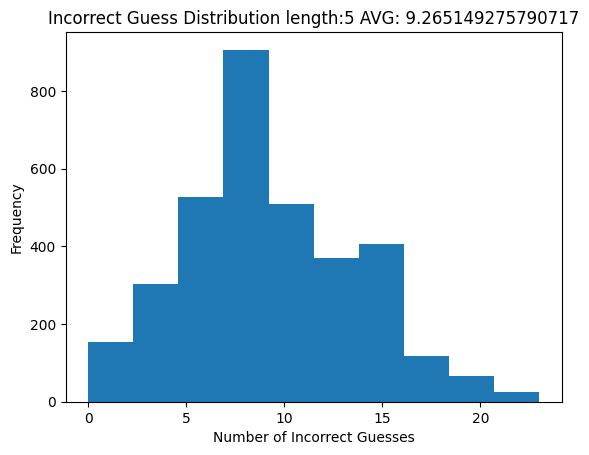

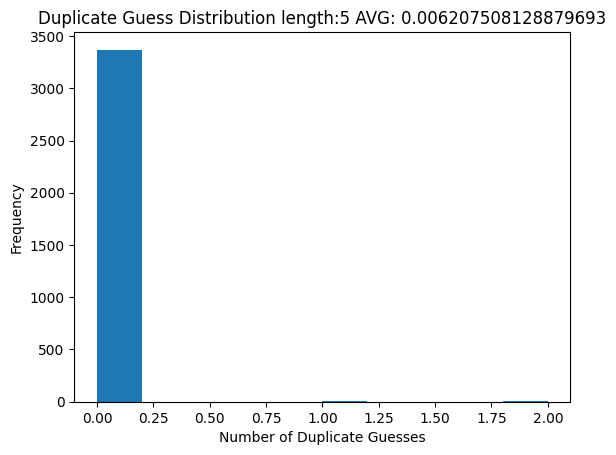

word length of 8
creating dataset


100%|███████████████████████████████████████████████████████████████████████| 571/571 [04:29<00:00,  2.12it/s]


total test words: 9136
total wins: 4032


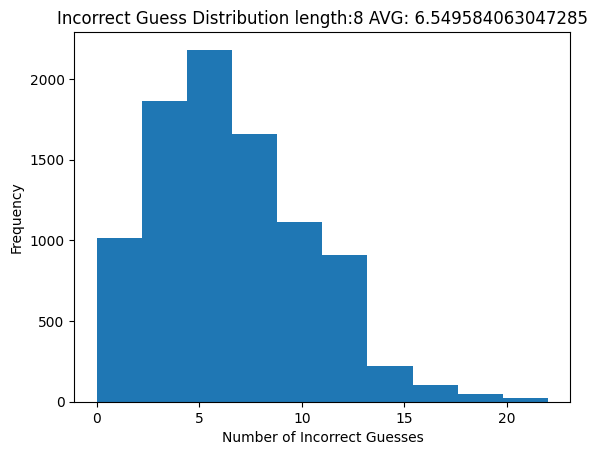

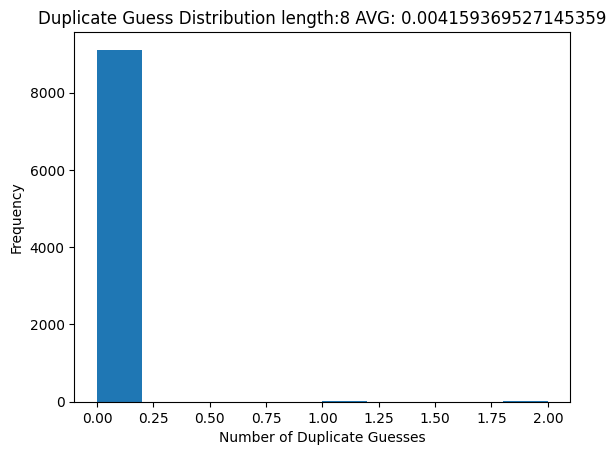

word length of 7
creating dataset


100%|███████████████████████████████████████████████████████████████████████| 487/487 [03:49<00:00,  2.12it/s]


total test words: 7785
total wins: 2791


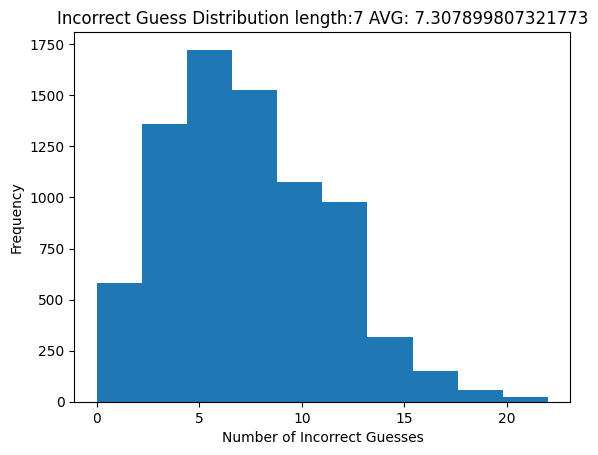

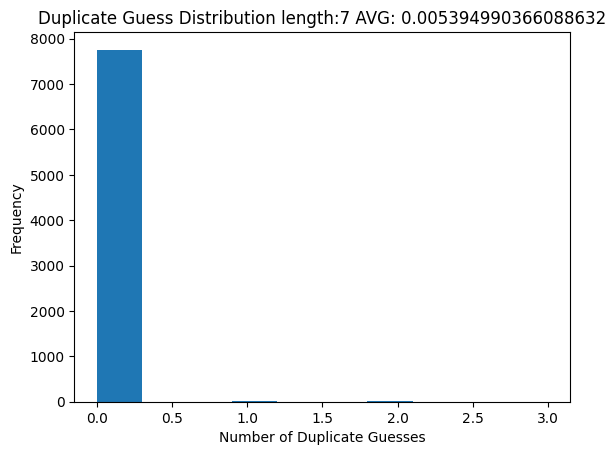

word length of 10
creating dataset


100%|███████████████████████████████████████████████████████████████████████| 506/506 [04:01<00:00,  2.10it/s]


total test words: 8086
total wins: 5015


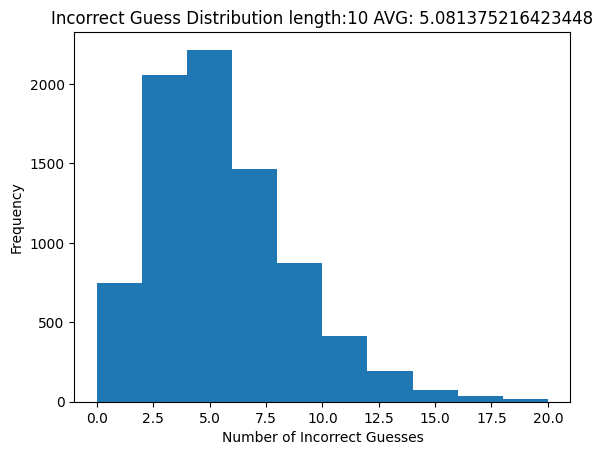

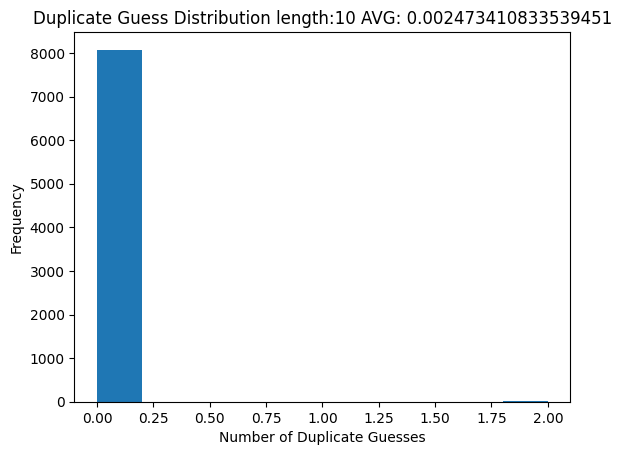

word length of 9
creating dataset


100%|███████████████████████████████████████████████████████████████████████| 580/580 [04:34<00:00,  2.12it/s]


total test words: 9272
total wins: 5093


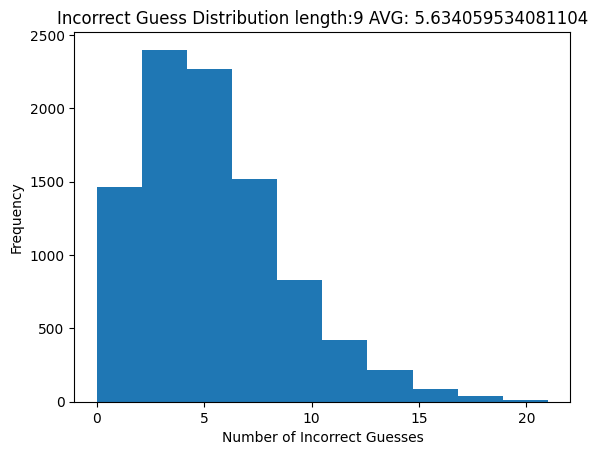

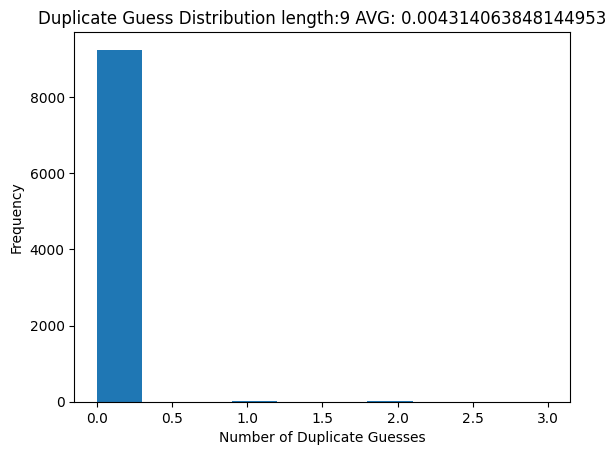

word length of 11
creating dataset


100%|███████████████████████████████████████████████████████████████████████| 428/428 [03:21<00:00,  2.12it/s]


total test words: 6836
total wins: 4837


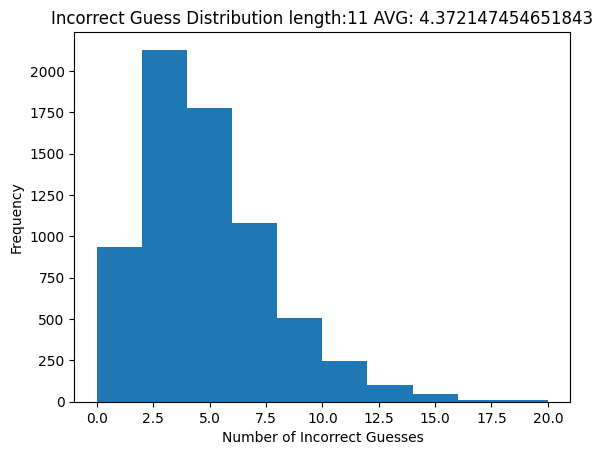

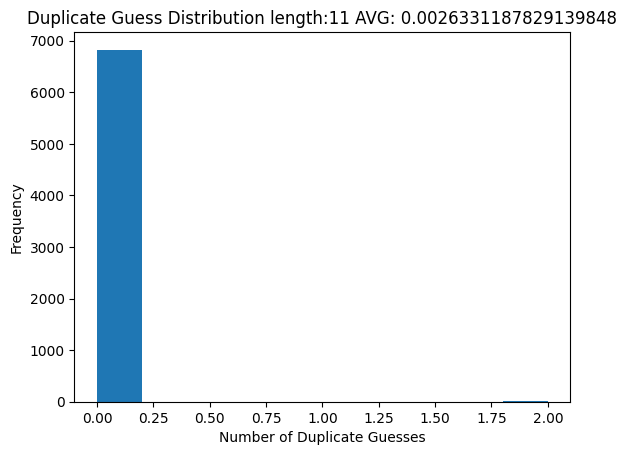

word length of 12
creating dataset


100%|███████████████████████████████████████████████████████████████████████| 341/341 [02:47<00:00,  2.03it/s]


total test words: 5454
total wins: 4231


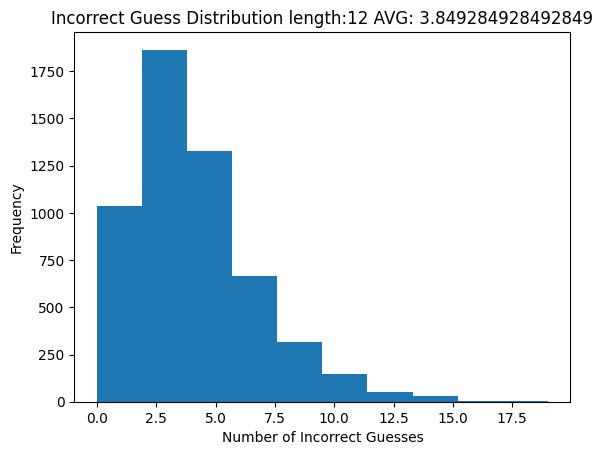

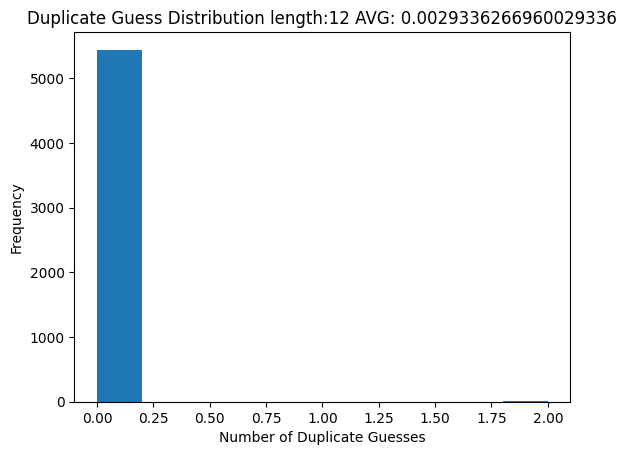

word length of 13
creating dataset


 59%|██████████████████████████████████████████                             | 144/243 [01:12<00:49,  1.98it/s]

In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.dataset import HangmanTestDataset
import numpy as np
import pickle

model.eval()
total_wins = 0

# To store the results length wise
result_dict = {'incorrectGuessesDict': dict(),
                'duplicateCountDict': dict(),
              }

for word_length, word_list in word_dict_by_len.items():
    print(f'word length of {word_length}')
    
    random.shuffle(word_list)
    split_idx = int(0.7 * len(word_list))
    test_dataset = HangmanTestDataset(word_list[split_idx:], max_word_length=word_length, max_guesses=26)
    dataloader = DataLoader(
            test_dataset,
            batch_size=16,
            num_workers=4,
        )
    
    
    incorrectGuessesList=[]
    duplicate_countList=[]
    with tqdm(dataloader) as pbar:
        for batch, wordNotYetGuessed, incorrectGuesses, trials, duplicate_count in pbar:
#             batch_no+=1
            batch['padded_encoder_input'] = batch['padded_encoder_input'].to(device)
            batch['encoder_input_mask'] = batch['encoder_input_mask'].to(device)
            batch['padded_guess_history'] = batch['padded_guess_history'].to(device)
            batch['guess_history_mask'] = batch['guess_history_mask'].to(device)
            batch['target_oneHot'] = batch['target_oneHot'].to(device)
            wordNotYetGuessed = wordNotYetGuessed.to(device)
            incorrectGuesses = incorrectGuesses.to(device)
            trials = trials.to(device)
            duplicate_count = duplicate_count.to(device)

            optimizer.zero_grad()

            for guess_number in range(test_dataset.max_guesses):
                decoder_out = model(batch['padded_encoder_input'], batch['padded_guess_history'], batch['encoder_input_mask'], batch['guess_history_mask'])
                preds = decoder_out[:, guess_number, :]

                #updating the state after each guess
                batch, wordNotYetGuessed, incorrectGuesses, trials, duplicate_count = test_dataset.update_state(batch, preds, guess_number, wordNotYetGuessed, incorrectGuesses, trials, duplicate_count)

                #all the words have been guessed so no need to guess anymore
                if wordNotYetGuessed.sum() == 0:
                    break


            incorrectGuessesList += incorrectGuesses.view(-1).tolist()
            duplicate_countList += duplicate_count.view(-1).tolist()
            
    
    result_dict['incorrectGuessesDict'][word_length] = incorrectGuessesList
    result_dict['duplicateCountDict'][word_length] = duplicate_countList
    
    wins = sum(1 for num in incorrectGuessesList if num < 6)
    total_wins +=wins
    print(f'total test words: {len(incorrectGuessesList)}')
    print(f'total wins: {wins}')
    
    plt.hist(incorrectGuessesList)
    plt.title(f"Incorrect Guess Distribution length:{word_length} AVG: {np.mean(incorrectGuessesList)}")
    plt.xlabel("Number of Incorrect Guesses")
    plt.ylabel("Frequency")
    plt.show()
    
    plt.hist(duplicate_countList)
    plt.title(f"Duplicate Guess Distribution length:{word_length} AVG: {np.mean(duplicate_countList)}")
    plt.xlabel("Number of Duplicate Guesses")
    plt.ylabel("Frequency")
    plt.show()

print(total_wins)
with open(f'results{checkpoint_file}.pkl', 'wb') as f:
    pickle.dump(result_dict, f)

In [8]:
import pickle
with open(f'test_results/results{checkpoint_file}.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

length: 1  support: 6   Wins = 1   Losses = 5  win% = 16.666666666666664

length: 2  support: 80   Wins = 4   Losses = 76  win% = 5.0

length: 3  support: 661   Wins = 45   Losses = 616  win% = 6.80786686838124

length: 4  support: 1587   Wins = 265   Losses = 1322  win% = 16.698172652804033

length: 5  support: 3383   Wins = 754   Losses = 2629  win% = 22.287910138929945

length: 6  support: 5863   Wins = 1702   Losses = 4161  win% = 29.029507078287565

length: 7  support: 7785   Wins = 2924   Losses = 4861  win% = 37.55940912010276

length: 8  support: 9136   Wins = 4115   Losses = 5021  win% = 45.04159369527145

length: 9  support: 9272   Wins = 5236   Losses = 4036  win% = 56.471095772217424

length: 10  support: 8086   Wins = 5088   Losses = 2998  win% = 62.92357160524363

length: 11  support: 6836   Wins = 4877   Losses = 1959  win% = 71.34289057928613

length: 12  support: 5454   Wins = 4230   Losses = 1224  win% = 77.55775577557755

length: 13  support: 3887   Wins = 3131   Los

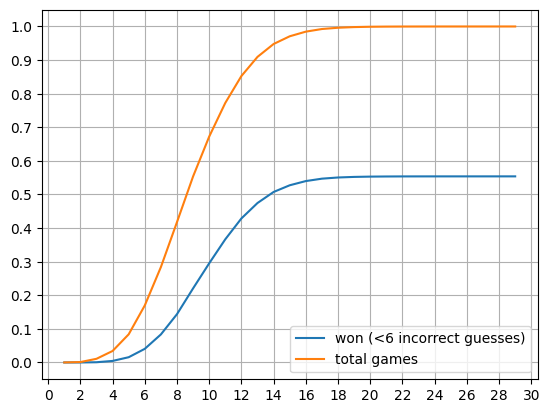

In [17]:
# for wordLen, inc_gues in loaded_data['incorrectGuessesDict'].items():
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
    
total_test_samples = 68204
word_lengths =  loaded_data['incorrectGuessesDict'].keys()
word_lengths = sorted(word_lengths)
for wordLen in word_lengths:
    inc_gues = loaded_data['incorrectGuessesDict'][wordLen]
    total_words = len(inc_gues)
    wins = sum(1 for num in inc_gues if num < 6)
    print(f'length: {wordLen}  support: {total_words}   Wins = {wins}   Losses = {total_words-wins}  win% = {wins/total_words*100}\n')
    
    
winsList=[]
totalList=[]
for wordLen in word_lengths:
    inc_gues = loaded_data['incorrectGuessesDict'][wordLen]
    total_words = len(inc_gues)
    wins = sum(1 for num in inc_gues if num < 6)
    if(wordLen == 1):
        totalList.append(total_words)
        winsList.append(wins)
    else:
        totalList.append(totalList[-1] + total_words)
        winsList.append(winsList[-1]+ wins)

for i in range(len(winsList)):
    winsList[i] = winsList[i]/total_test_samples
    totalList[i] = totalList[i]/total_test_samples
plt.plot(word_lengths, winsList, label='won (<6 incorrect guesses)')
plt.plot(word_lengths, totalList, label='total games')
plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))
plt.gca().xaxis.set_major_locator(MultipleLocator(2))
plt.grid(True)
plt.legend()
    

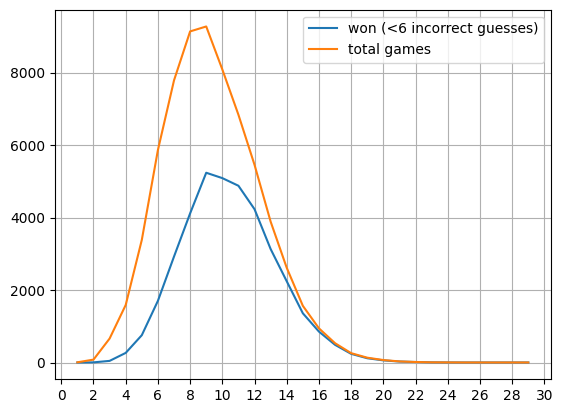

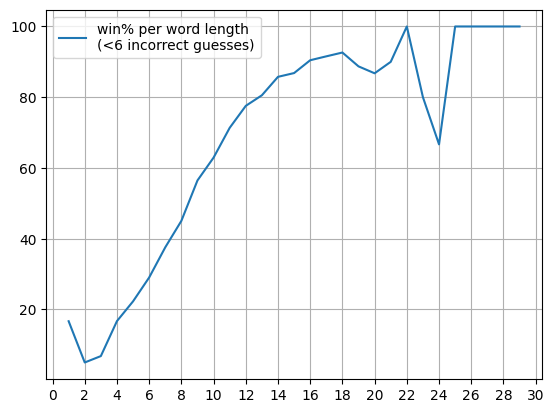

In [20]:
# for wordLen, inc_gues in loaded_data['incorrectGuessesDict'].items():
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
    
winsList=[]
totalList=[]
for wordLen in word_lengths:
    inc_gues = loaded_data['incorrectGuessesDict'][wordLen]
    total_words = len(inc_gues)
    wins = sum(1 for num in inc_gues if num < 6)
    totalList.append(total_words)
    winsList.append(wins)

# for i in range(len(winsList)):
#     winsList[i] = winsList[i]/total_test_samples
#     totalList[i] = totalList[i]/total_test_samples
plt.plot(word_lengths, winsList, label='won (<6 incorrect guesses)')
plt.plot(word_lengths, totalList, label='total games')
# plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))
plt.gca().xaxis.set_major_locator(MultipleLocator(2))
plt.grid(True)
plt.legend()
plt.show()

plt.plot(word_lengths, [i*100/j for i,j  in zip(winsList,totalList)], label='win% per word length\n(<6 incorrect guesses)')
plt.gca().xaxis.set_major_locator(MultipleLocator(2))
plt.grid(True)
plt.legend()
plt.show()